# Trajectory Optimisation in Multimodal Dynamical Systems via Latent-ODE Collocation
This notebook provides a basic example of the code used to generate the figues in our ICRA 2021 paper "Trajectory Optimisation in Multimodal Dynamical Systems via Latent-ODE Collocation".

In [1]:
import gpjax
import scipy as sp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.optimize import NonlinearConstraint
from tromp.constraints import hermite_simpson_collocation_constraints_fn
from tromp.manifold import GPManifold
from tromp.objective_fns import sum_of_squares_objective
from tromp.plotting.gp import plot_svgp_mean_and_var
from tromp.plotting.trajectories import plot_start_and_end_pos, plot_trajectory
from tromp.trajectories import DiscreteTrajectory

/Users/aidanscannell/.pyenv/versions/3.8.6/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


Let's load the learned SVGP and plot it's mean and variance to see what we're working with. We can also define our start postion and our target end position. Our aim is to find a trajectory between `pos_init` and `pos_end_targ` that remains in our desired mode and avoids regions of the gating function with high posterior variance.

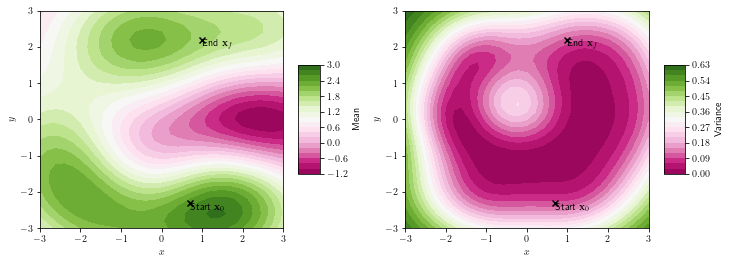

In [2]:
def init_svgp_gpjax_from_gp_npz(npz_file):
    gp = jnp.load(npz_file)
    kernel = gpjax.kernels.RBF(variance=gp["variance"], lengthscales=gp["lengthscales"])
    svgp = gpjax.models.SVGP(
        kernel,
        likelihood=gpjax.likelihoods.Bernoulli(),
        inducing_variable=gp["Z"],
        mean_function=gpjax.mean_functions.Zero(),
        num_latent_gps=1,
        q_diag=False,
        q_mu=gp["q_mu"],
        q_sqrt=gp["q_sqrt"],
        whiten=True
    )
    return svgp

# Load a SVGP gating function from an svgp .npz file
gp_npz_file = "./trained-mogpe-params/icra_param_dict.npz"
svgp = init_svgp_gpjax_from_gp_npz(gp_npz_file)

# Initialise start and end positions
pos_init = jnp.array([0.7, -2.3])
pos_end_targ = jnp.array([1.0, 2.2])
input_dim = pos_init.shape[0]

fig, axs = plot_svgp_mean_and_var(svgp)
for ax in axs:
    plot_start_and_end_pos(fig, ax, pos_init, pos_end_targ)

Let's create an instance of `tromp.trajectories.DiscreteTrajectory` to represent our trajectory. This class initialises a straight line trajectory between `pos_init` and `pos_end_targ` and initialises the solver times in [0, 1] if none are passed to its constructor. Let's also take a look at our inital discretised trajectory by plotting it over the gp's mean and variance.

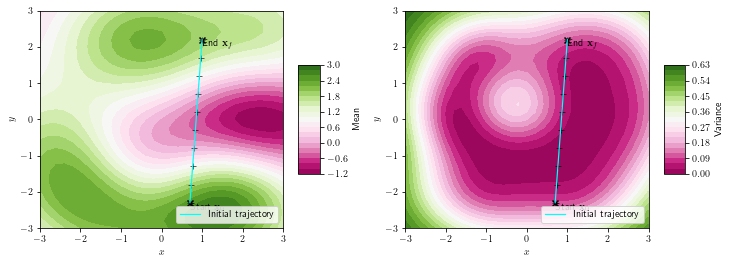

In [3]:
trajectory = DiscreteTrajectory(pos_init, pos_end_targ)

fig, axs = plot_svgp_mean_and_var(svgp)
for ax in axs:
    plot_start_and_end_pos(fig, ax, pos_init, pos_end_targ)
    plot_trajectory(fig, ax, trajectory.state_guesses, color="cyan", label="Initial trajectory")

As we have our SVGP we can initialise a `GPManifold` by passing it the `gpjax.models.SVGP` object we just created. Our `GPManifold` is governed by its expected Riemannian metric tensor,
\begin{align} \label{eq-expected-metric}
  \mathbb{E}[\mathbf{G}] = \mathbb{E}[\mathbf{J}^T] \mathbb{E}[\mathbf{J}] + \lambda \mathbf{\Sigma}_J,
\end{align}
where $\mathbf{J}$ is the Jacobian of the gating function. As the differential operator is linear the Jacobian of a GP is also a GP, giving,

\begin{align*} \label{eq-predictive-jacobian-dist}
p\left(\mathbf{J}_* \mid \mathbf{x}_*, {\xi}^{(k)}\right)
&=\int q\left(\hat{\mathbf{h}}^{(k)}\right) p\left(\mathbf{J}_* \mid \mathbf{x}_*, \hat{\mathbf{h}}^{(k)}, \xi^{(k)}\right) \text{d} \hat{\mathbf{h}}^{(k)} \\
&= \mathcal{N}\left(\mathbf{J}_* \mid \mu_J, \mathbf{\Sigma}_{J}\right).
\end{align*}

In [15]:
covariance_weight = 20
covariance_weight = 1.0
covariance_weight = 0.5
manifold = GPManifold(gp=svgp, covariance_weight=covariance_weight)

Let's also write a wrapper around the manifold's `geodesic_ode` function as the collocation constraints calculation requires this `ode_fn` to calculate the collocation defects. The geodesic ODE is given by,

\begin{align} \label{eq-2ode}
 \ddot{\mathbf{x}}(t)
&= f_G(t, \dot{\mathbf{x}}, \mathbf{x}) \\
&=-\frac{1}{2} \mathbf{G}^{-1}(\mathbf{x}(t))\left[\frac{\partial \operatorname{vec}[\mathbf{G}(\mathbf{x}(t))]}{\partial \mathbf{x}(t)}\right]^{T}\left(\dot{\mathbf{x}}(t) \otimes \dot{\mathbf{x}}(t)\right)
\end{align}

In [18]:
def ode_fn(times, states):
    pos = states[0 : input_dim]
    vel = states[input_dim:]
    return manifold._geodesic_ode(pos, vel)

The goals of our trajectory optimisation are encoded via the geodesic ODE so all we need to do now is solve it subject to our boundary conditions. We solve the geodesic ODE by transcribing it using Hermite-Simpson collocation. We can use the `hermite_simpson_collocation_constraints_fn` function to define a set of collocation constraints that ensure trajectories are solutions to the geodesic ODE. The constraints at the mid points between each collocation point are given by,

\begin{align} \label{eq-defect}
\Delta_{i+\frac{1}{2}} &= \ddot{\mathbf{z}}_{{i+\frac{1}{2}}} - f_G(t_{{i+\frac{1}{2}}}, \dot{\mathbf{z}}_{{i+\frac{1}{2}}},\mathbf{z}_{{i+\frac{1}{2}}})
\end{align}

where $\mathbf{z}_{{i+\frac{1}{2}}}, \dot{\mathbf{z}}_{{i+\frac{1}{2}}},\ddot{\mathbf{z}}_{{i+\frac{1}{2}}}$ are obtained by interpolating the state and it's derivatives from the collocation points.

In [23]:
@jax.jit
def constraints_fn(state_at_knots):
    state_at_knots = trajectory.opt_vars_to_state_guesses(state_at_knots)
    return hermite_simpson_collocation_constraints_fn(
        state_at_knots, trajectory.times, ode_fn=ode_fn
    )


constraints_lower_bound = -0.2
constraints_upper_bound = 0.2
# constraints_lower_bound = -0.1
# constraints_upper_bound = 0.1
constraints = NonlinearConstraint(constraints_fn, constraints_lower_bound, constraints_upper_bound)

We can use any objective function alongside our collocation constraints.

In [24]:
@jax.jit
def objective_fn(opt_vars):
    state_guesses = trajectory.opt_vars_to_state_guesses(opt_vars)
    pos_guesses = state_guesses[:, :input_dim]
    sum_of_squares = jnp.sum(pos_guesses ** 2)
    return 1.0
#     return sum_of_squares

## Optimise Trajectory with SLSQP in SciPy
The nonlinear program that this work solves is given by,
\begin{align} \label{eq-}
\min_{\mathbf{z}(t), \dot{\mathbf{z}}(t)}& \int_{t_0}^{t_f} 1 \text{d}t \\
&\text{s.t. } \\
\ddot{\mathbf{x}}(\mathbf{z}(t), \dot{\mathbf{z}}(t)) &= f_G(t, \dot{\mathbf{x}}(\mathbf{z}(t), \dot{\mathbf{z}}(t)), \mathbf{x}(\mathbf{z}(t), \dot{\mathbf{z}}(t))) \\
\mathbf{x}&\left(\mathbf{z}(t_0), \dot{\mathbf{z}}(t_0) \right) = \mathbf{x}_0, \quad \\
\mathbf{x}&(\mathbf{z}(t_f),\dot{\mathbf{z}}(t_f)) = \mathbf{x}_f
%c&(\mathbf{x}(\mathbf{z}(t), \dot{\mathbf{z}}(t)), \mathbf{u}(\mathbf{z}(t), \dot{\mathbf{z}}(t)) \leq 0 \quad \forall t
\end{align}

In [25]:
maxiter = 500  # max number of iterations
method = "SLSQP"
opt_vars = trajectory.state_guesses_to_opt_vars(trajectory.state_guesses.flatten())

optimisation_result = sp.optimize.minimize(
    objective_fn,
    opt_vars,
    method=method,
    constraints=constraints,
    options={"maxiter": maxiter},
)
print(optimisation_result)

     fun: DeviceArray(1., dtype=float64)
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3298
     nit: 84
    njev: 84
  status: 0
 success: True
       x: array([ 1.52098424,  0.8622488 ,  0.84775368, -1.91468248,  4.43183034,
        1.88444705,  0.81931665, -1.59734068,  5.49194845,  1.73014708,
        0.28978213, -0.97599386, -6.21383963, -0.07762402,  0.79244672,
       -0.53352013, -2.15679525,  0.76343765,  0.46242299, -0.22332483,
        0.20437826,  0.5830892 ,  0.38924456,  0.12535651,  1.01714674,
        1.61434188,  0.45924619,  0.71059344,  1.53429533,  1.92664979,
        0.71080237,  1.41190781,  2.62160285,  2.72477172, -0.44563674,
        3.55112952])


In [26]:
optimised_trajectory = trajectory.opt_vars_to_state_guesses(optimisation_result.x)

Let's visualise our optimised trajectory by plotting it over the gp's mean and variance.

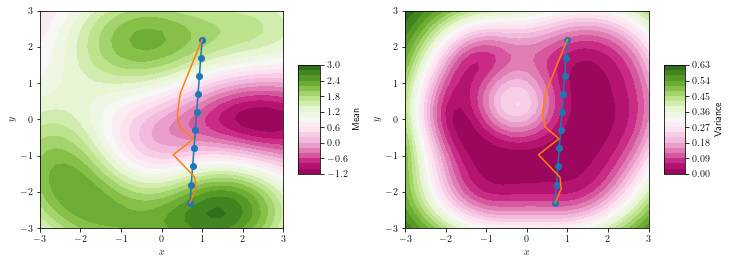

In [28]:
fig, axs = plot_svgp_mean_and_var(svgp)
for ax in axs:
    trajectory.plot(fig, ax)
    ax.plot(optimised_trajectory[:, 0], optimised_trajectory[:, 1])